# Overview (WIP)

The goal of this Jupyter notebook is to answer the following question: **What percentage of allophones of a given language are in the minimal feature representation of the language's phonemic inventory (after dimentionality reduction)**?

The sections we have (or will have are):
- Loading the dataframe and compiling preliminary statistics on the data available in Phoible
    - Including removing inventories with no allophones
- Adding feature representations to allophones without features (not in this notebook, but the allophones without feature reps will be found/mentioned here)
    - MAYBE also write a script to see which allophones shouldn't be included (e.g. 'ja')
- Iterate over the inventories and apply dimensionality reduction to find the smallest number of features which are able to describe all the contrasts that exist in the language. Then, see which allophones are able to be accurately (contrastively? faithfully?) represented by this reduced subset of features 

# Todo
- Go back and change the loops to df.apply for safer iteration

# Load the Dataframe

Much code used from https://github.com/zyocum/phoible-notebook/blob/main/notebook.ipynb 

In [2]:
# Import pandas

from collections import defaultdict
import pandas as pd

In [16]:
# Download the dataframe

df = pd.read_csv('https://raw.githubusercontent.com/phoible/dev/master/data/phoible.csv', low_memory=False)

In [3]:
df

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,lenis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,-,-,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,-,-,-,-,+,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant,...,-,-,-,-,+,-,-,-,-,-
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant,...,-,-,-,-,-,-,-,-,-,-
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0


In [5]:
df.iloc[0]

InventoryID                       1
Glottocode                 kore1280
ISO6393                         kor
LanguageName                 Korean
SpecificDialect                 NaN
GlyphID                        0068
Phoneme                           h
Allophones                    ç h ɦ
Marginal                        NaN
SegmentClass              consonant
Source                          spa
tone                              0
stress                            -
syllabic                          -
short                             -
long                              -
consonantal                       -
sonorant                          -
continuant                        +
delayedRelease                    +
approximant                       -
tap                               -
trill                             -
nasal                             -
lateral                           -
labial                            -
round                             0
labiodental                 

# Set up the analysis

In [6]:
# Map the index of the dataframe to the language name

index_to_language = dict(df[['InventoryID', 'LanguageName']].values)

In [7]:
print(index_to_language[3020])

len(index_to_language)

Tableland Lamalama


3020

In [8]:
# Find all inventories with at least one NaNs in the Allophones column

nan_inventories = set(df[df['Allophones'].isna()]['InventoryID'].values)
print(len(nan_inventories))

1688


In [9]:
# Find inventories with only non-NaNs

defined_inventories = set(df.groupby('InventoryID').filter(lambda x: x['Allophones'].isna().sum() != len(x))['InventoryID'].values)
print(len(defined_inventories))

1332


In [10]:
# Find inventories where each phoneme in an inventory maps to exactly one allophone 387
meaningful_allophone_inventories = set()
for inventory, phonemes in df.groupby('InventoryID'):
    if inventory in defined_inventories: # Only go through if it's defined
        for index, row in phonemes.iterrows():
            if row['Phoneme'] != row['Allophones']:
                meaningful_allophone_inventories.add(inventory)
defined_no_allophone_inventories = {ID for ID in defined_inventories if ID not in meaningful_allophone_inventories}
print(f'There are {len(defined_no_allophone_inventories)} inventories with no meaningful allophones')
print(f'These are inventories {sorted(defined_no_allophone_inventories)}')

There are 387 inventories with no meaningful allophones
These are inventories [3, 26, 41, 173, 649, 650, 651, 655, 656, 659, 660, 663, 664, 666, 667, 668, 669, 670, 671, 672, 675, 676, 677, 679, 680, 681, 682, 683, 684, 686, 687, 688, 692, 693, 695, 696, 697, 698, 699, 700, 701, 702, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 724, 725, 727, 729, 730, 732, 733, 735, 737, 738, 739, 740, 741, 743, 744, 746, 748, 749, 751, 752, 753, 754, 756, 759, 762, 763, 764, 765, 766, 768, 769, 770, 771, 772, 776, 777, 779, 782, 783, 784, 787, 788, 789, 792, 793, 794, 795, 796, 797, 800, 801, 805, 806, 807, 809, 810, 811, 812, 813, 814, 816, 818, 819, 820, 822, 826, 827, 829, 830, 831, 832, 833, 834, 835, 836, 837, 842, 843, 844, 846, 847, 848, 849, 850, 852, 853, 859, 860, 863, 864, 868, 869, 870, 872, 873, 874, 877, 878, 879, 902, 903, 912, 916, 924, 926, 931, 933, 936, 942, 946, 951, 952, 960, 963, 964, 986, 989, 991, 993, 999, 1023, 1033, 1041, 1047, 1049, 1063,

The total number of inventories is equal to the number of NaN-only columns and mixed columns. This means that every inventory either is all-NaNs or all non-nans

In [11]:
# Define a function which returns true if a phoneme is in the list of phonemes

def is_defined(phoneme):
    return phoneme in df['Phoneme'].values

In [12]:
# Check to see which phonemes don't have allophones

allophone_counts = defaultdict(int)
undefined_allophones = set()

# For each inventory with meaningful allophones
for inventory in sorted(meaningful_allophone_inventories):
    # For each phoneme in that inventory
    for _, phoneme in df[df['InventoryID'] == inventory].iterrows():
        # For each allophone of that phoneme
        for allophone in phoneme['Allophones'].split():
            allophone_counts[allophone] += 1
            if not is_defined(allophone):
                undefined_allophones.add(allophone)
    if inventory % 5 == 0:
        print(inventory)


all_allophones = allophone_counts.keys()

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
665
685
690
745
750
755
760
775
780
785
790
815
825
840
845
855
865
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1155
1160
1165
1170
1175
1185
1190
1210
1215
1220
1225
1230
1255
1260
1265
1285
1290
1295
1300
1315
1320
1325
1330
1340
1350
1355
1365
1375
1380
1385
1390
1395
1400
1405
1410
1415
1435
1440
1445
1455
1470
1475
1480
1500
1510
1520
1535
1550
1565
1570
1575
1585
1590
1600
1605
1610
1625
1630
1635
1650
1655
1660
1665
1670
1675
1680
1685
1690
2160
2165
2170
2175
2180
2185
2190
2195
2200
2205
2210
2215
2220
2225
2230
2235


# Get data on the inventories

In [13]:
# Of the inventories with allophones, how many phonemes and allophones do they have?
# Only considers inventories with defined allophones
id_to_phoneme_count = {} # Maps an ID number to the number of phonemes
id_to_allophone_count = {} # Maps an ID number to the number of phonemes
id_to_allophone_phoneme_ratio = {} # Maps an ID number to the ratio of allophones to phonemes
for inventory, phonemes in df.groupby('InventoryID'):
    if inventory in defined_inventories: # Only go through if it's defined
        num_allophones = 0
        for allophones in phonemes:
            num_allophones += len(allophones.split() )
        id_to_phoneme_count[inventory] = len(phonemes)
        id_to_allophone_count[inventory] = num_allophones
        id_to_allophone_phoneme_ratio[inventory] = num_allophones / len(phonemes)

In [14]:
average_allophone_phoneme_ratio = sum(id_to_allophone_phoneme_ratio.values() ) / len(id_to_allophone_phoneme_ratio)
print(f'The average ratio of allophones to phonemes is {average_allophone_phoneme_ratio}')
print(f'There are {average_allophone_phoneme_ratio - 1} more allophones than phonemes')

The average ratio of allophones to phonemes is 1.3943044299461032
There are 0.39430442994610315 more allophones than phonemes


In [15]:
# How many of the allophones are already in the inventory?

# Get all the phonemes in an inventory
inventory_phonemes = defaultdict(set)
# For each inventory with meaningful allophones
for inventory in sorted(meaningful_allophone_inventories):
    # For each phoneme in that inventory
    for _, phoneme in df[df['InventoryID'] == inventory].iterrows():
        inventory_phonemes[inventory].add(phoneme['Phoneme'])

# Get all the allophones in an inventory
inventory_allophones = defaultdict(set)
# For each inventory with meaningful allophones
for inventory in sorted(meaningful_allophone_inventories):
    # For each phoneme in that inventory
    for _, phoneme in df[df['InventoryID'] == inventory].iterrows():
        # For each allophone of that phoneme
        for allophone in phoneme['Allophones'].split():
            inventory_allophones[inventory].add(allophone)

In [16]:
# Check to see how many of the allophones already exist within the phonemic inventory
allophone_percent_outside_inventory = {}
# For each inventory with meaningful allophones
for inventory in sorted(meaningful_allophone_inventories):
    allophone_percent_outside_inventory[inventory] = len(inventory_allophones[inventory]) / len(inventory_phonemes[inventory]) - 1

In [17]:
average_allophone_percent_outside_inventory = sum(allophone_percent_outside_inventory.values() ) / len(allophone_percent_outside_inventory)
print(f'The average percent of allophones outside the phonemic inventory is {average_allophone_percent_outside_inventory}')
print(f'This means that {average_allophone_percent_outside_inventory / (average_allophone_phoneme_ratio - 1)}% of allophones lie outside the inventory')

The average percent of allophones outside the phonemic inventory is 0.33712105332857684
This means that 0.8549765808480959% of allophones lie outside the inventory


# Get data on the allophones

In [18]:
# Return the number of allophones and unique allophones
print(f'There are {len(allophone_counts)} allophones')
print(f'{len(undefined_allophones)} don\'t have feature representations')

There are 3034 allophones
1016 don't have feature representations


In [19]:
# Account for marginality
marginal_defined_allophones = set()
nonmarginal_undefined_allophones = set()
for undefined_allophone in undefined_allophones:
    # If it's marginal and exists nonmarginally
    if (undefined_allophone.startswith("<") and is_defined(undefined_allophone[1:-1]) ) or (is_defined("<" + undefined_allophone + ">") ):
        marginal_defined_allophones.add(undefined_allophone)
    else:
        nonmarginal_undefined_allophones.add(undefined_allophone)


In [20]:
# Return info on the marginality of some allophones
print(f'Of the {len(undefined_allophones)} without feature representations:')
print(f'{len(marginal_defined_allophones)} have feature representations when accounting for marginality')
print(f'These are {marginal_defined_allophones}')
print(f'{len(nonmarginal_undefined_allophones)} still don\'t feature representations when accounting for marginality')

Of the 1016 without feature representations:
7 have feature representations when accounting for marginality
These are {'<o>', '<ɯ>', '<ɲ̟>', '<y>', '<ɾ>', '<œ>', '<q>'}
1009 still don't feature representations when accounting for marginality


In [21]:
# Filter by the number of times they appear
nonunique_allophones = {key for key, value in allophone_counts.items() if value > 1}
nonunique_undefined_allophones = {key for key, value in allophone_counts.items() if value > 1 and key in nonmarginal_undefined_allophones}
print(f'There are {len(nonunique_allophones)} allophones that appear more than once.')
print(f'Of those, {len(nonunique_undefined_allophones)} don\'t have feature representations.')
print(f'These are {nonunique_undefined_allophones}')

There are 1294 allophones that appear more than once.
Of those, 174 don't have feature representations.
These are {'k̃', 'ɖʲ', 'jə', 't̻̚', 'β̞̃', 'ʔk', 'ʀ̥ʁ̥', 'ʔr', 'ʔp', 'ʁ̥', 'ʔ̚', 'j͉', 'ʃˤː', 'xˑ', 'k̬', 'mm̥', 'ă̟', 'ɖ̚', 'ɟ̚', 'b̚', 'pfʷ', 'k͈ʷː', 'ɣ̞', 'ɑ̥', 'ʃ̩', 'nʷˠ', 'ɨ̟', 'ɦ̃', 'ɣ̃', 'lʷˠ', 'k̚ʷ', 't̪̚', 'ə̯iː', 'ŋm̩', 'ʔt', 'h̃ʲ', 'ɲʲ', 't̠ʃʲʼ', 'ɡŋ', 'vʷˠ', 'ʔʰ', 'ŋw̃', 'bˡ', 'ĭ̥', 'ʔp̚', 'ɡ̠', 'ʲt̚', 'ʒ̥', 'ɽ̥', 'k̟̚', 'ɡ̚', 'uʔ', 'n̠d̠ʒʲ', 'nɪ̯', 'ʔb', 'ɗ̚', 'nʒ', 'ĭ̃', 'ø̥', 'ʊ̥̆', 'tʔ', 'ɪ̥', 'hw', 'f̃', 'sʷˠ', 'd̠̈', 'wʊ', 's̃', 'q̚', 'ʔm', 'ɳ̩', 'ɣ̟', 't̚', 'ɛ˞', 'ɡ̃', 'β̥', 'k̠', 'ɟɲ', 'ɡ̥', 'ʒ̃', 't̥̚', 't̪ⁿ', 'ja', 't̃', 'ɰʷ', 'lɪ̯', 'tⁿ', 'k͉̚', 'd̚', 'œə', 'β̞̜', 'ə̥̆', 'pˡ', 'ɐ̥', 'k̚', 'ɻ̥', 'ɛ̥', 'r̞', 't̠ʃ̚', 'ñ', '∅', 'i̠ː', 'x̟', 'kʔ', 'dɪ̯', 'k̟ʲ', 'p̚ˀ', 'tːʃ', 'tʰɪ̯', 'd̠ʒ̥', 'ʔn', 'ə̝', 'l̩ˠ', 'ʀ̥', 'o̥', 'ɐ˞', 'ɔ̥', 'm̥ˠ', 'nn̥', 'kp̚', 'ʈʲʰ', 'ɪ̥̆', 'ʊ˞', 'ŋ̚', 'ʛ', 'ɡ̥̊', 'ʈ̚', 'o̞ə̯', 'd̠̥z̠̥ʲ', 's̬', 'ɱvʷ', 'tˡ', 'pⁿ', 'pʔ', 'ɟ̥', 'ɱ̩', '↘'

# Add automatic feature representations where possible

Everything below here is messy and will be cleaned up soon. I needed to write out a lot of stuff to pass the dataframe through add-features.R and will clean it up after add-features.R is updated.

In [11]:
df.to_csv('original_df.csv', encoding='utf-8')

In [12]:
df

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,lenis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,-,-,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,-,-,-,-,+,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant,...,-,-,-,-,+,-,-,-,-,-
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant,...,-,-,-,-,-,-,-,-,-,-
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0


In [13]:
# Convert the allophones into different rows

allophoned_df = pd.DataFrame(columns=df.columns.tolist()[:11] )
allophoned_df = allophoned_df.rename(columns={'Phoneme': 'OriginalPhoneme', 'Allophones': 'Phoneme'})

In [14]:
# Add each row

for index, phoneme in df.copy().rename(columns={'Phoneme': 'OriginalPhoneme', 'Allophones': 'Phoneme'}).iterrows():
    if not pd.isna(phoneme['Phoneme']):
        for allophone in phoneme['Phoneme'].split():
            new_allophone = phoneme.copy()
            new_allophone['Phoneme'] = allophone
            allophoned_df.loc[len(allophoned_df.index)] = new_allophone
    if index % 1000 == 0:
        print(f'Progress is {index / len(df.index)}')

Progress is 0.0
Progress is 0.0094801107276933
Progress is 0.0189602214553866
Progress is 0.028440332183079897
Progress is 0.0379204429107732
Progress is 0.0474005536384665
Progress is 0.056880664366159794
Progress is 0.0663607750938531
Progress is 0.0758408858215464
Progress is 0.08532099654923969
Progress is 0.094801107276933
Progress is 0.1042812180046263
Progress is 0.11376132873231959
Progress is 0.1232414394600129
Progress is 0.1327215501877062
Progress is 0.14220166091539949
Progress is 0.1516817716430928
Progress is 0.1611618823707861
Progress is 0.17064199309847938
Progress is 0.1801221038261727
Progress is 0.189602214553866
Progress is 0.19908232528155928
Progress is 0.2085624360092526
Progress is 0.2180425467369459
Progress is 0.22752265746463918
Progress is 0.23700276819233249
Progress is 0.2464828789200258
Progress is 0.2559629896477191
Progress is 0.2654431003754124
Progress is 0.2749232111031057
Progress is 0.28440332183079897
Progress is 0.2938834325584923
Progress is 0

In [15]:
allophoned_df

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,OriginalPhoneme,Phoneme,Marginal,SegmentClass,Source
0,1,kore1280,kor,Korean,NaN,0068,h,ç,NaN,consonant,spa
1,1,kore1280,kor,Korean,NaN,0068,h,h,NaN,consonant,spa
2,1,kore1280,kor,Korean,NaN,0068,h,ɦ,NaN,consonant,spa
3,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,spa
4,1,kore1280,kor,Korean,NaN,006B,k,k̚,NaN,consonant,spa
...,...,...,...,...,...,...,...,...,...,...,...
65464,2238,even1259,evn,Evenki,NaN,006F+02D0,oː,oː,False,vowel,ph
65465,2238,even1259,evn,Evenki,NaN,0075,u,u,False,vowel,ph
65466,2238,even1259,evn,Evenki,NaN,0075+02D0,uː,uː,False,vowel,ph
65467,2238,even1259,evn,Evenki,NaN,0259,ə,ə,False,vowel,ph


In [16]:
def unicode_hex(phoneme):
    unicodes = []
    for character in phoneme:
        code_point = ord(character)
        unicodes.append('{:04X}'.format(code_point) )
    return '+'.join(unicode for unicode in unicodes)

In [17]:
# Update each row's GlyphID

for index, phoneme in allophoned_df.iterrows():
    phoneme['GlyphID'] = unicode_hex(phoneme['Phoneme'])
    if index % 10000 == 0:
        print(f'Progress is {index / len(df.index)}')

Progress is 0.0
Progress is 0.094801107276933
Progress is 0.189602214553866
Progress is 0.28440332183079897
Progress is 0.379204429107732
Progress is 0.47400553638466497
Progress is 0.5688066436615979


In [18]:
allophoned_df

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,OriginalPhoneme,Phoneme,Marginal,SegmentClass,Source
0,1,kore1280,kor,Korean,NaN,00E7,h,ç,NaN,consonant,spa
1,1,kore1280,kor,Korean,NaN,0068,h,h,NaN,consonant,spa
2,1,kore1280,kor,Korean,NaN,0266,h,ɦ,NaN,consonant,spa
3,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,spa
4,1,kore1280,kor,Korean,NaN,006B+031A,k,k̚,NaN,consonant,spa
...,...,...,...,...,...,...,...,...,...,...,...
65464,2238,even1259,evn,Evenki,NaN,006F+02D0,oː,oː,False,vowel,ph
65465,2238,even1259,evn,Evenki,NaN,0075,u,u,False,vowel,ph
65466,2238,even1259,evn,Evenki,NaN,0075+02D0,uː,uː,False,vowel,ph
65467,2238,even1259,evn,Evenki,NaN,0259,ə,ə,False,vowel,ph


In [19]:
allophoned_df.to_csv('allophoned_df.csv', encoding='utf-8')

In [3]:
# When picking up from halfway, continue from here

allophoned_df = pd.read_csv('allophoned_df.csv', low_memory=False)

In [4]:
allophone_copy = allophoned_df.copy()

In [5]:
allophoned_df = allophone_copy.copy()

In [33]:
allophoned_df['Unhandled'] = False

In [34]:
# These are also unhandled
unhandled_characters = ['0334', '2198', '1D4A', '2205']
unhandled_inventories = set()
for index, phone in allophoned_df.iterrows():
    # Mark unhandled characters
    for unhandled_character in unhandled_characters:
        if unhandled_character in phone['GlyphID']:
            allophoned_df.at[index, 'Unhandled'] = True
    if ("0353" in phone["GlyphID"] or "0308" in phone["GlyphID"]) and "d" in phone["Phoneme"]:
        allophoned_df.at[index, 'Unhandled'] = True
    if allophoned_df.at[index, 'Unhandled']:
        unhandled_inventories.add((allophoned_df.iloc[index]["InventoryID"], phone["Phoneme"]))
print(unhandled_inventories)

{(62, 'ɔ̴ː'), (2192, '↘'), (2204, '∅'), (2215, '∅'), (2196, 'd̠͓'), (62, 'ə̴ː'), (1407, 'ɛᵊ'), (2217, '∅'), (1407, 'iᵊ'), (2230, '∅'), (2236, 'd̠̈'), (2223, '∅'), (62, 'ɑ̴'), (62, 'ə̴'), (62, 'ɔ̴'), (2211, '∅'), (62, 'ɑ̴ː'), (2200, '∅'), (2222, '∅'), (2202, '∅')}


In [35]:
print(sorted(unhandled_inventories))

[(62, 'ɑ̴'), (62, 'ɑ̴ː'), (62, 'ɔ̴'), (62, 'ɔ̴ː'), (62, 'ə̴'), (62, 'ə̴ː'), (1407, 'iᵊ'), (1407, 'ɛᵊ'), (2192, '↘'), (2196, 'd̠͓'), (2200, '∅'), (2202, '∅'), (2204, '∅'), (2211, '∅'), (2215, '∅'), (2217, '∅'), (2222, '∅'), (2223, '∅'), (2230, '∅'), (2236, 'd̠̈')]


In [17]:
allophoned_df[allophoned_df['InventoryID'] == 2200].iloc[0:20]

,Unnamed: 0,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,OriginalPhoneme,Phoneme,Marginal,SegmentClass,Source,Unhandled
62969,62969,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,0066,f,f,False,consonant,ph,False
62970,62970,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,0068,h,h,False,consonant,ph,False
62971,62971,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006A,j,j,False,consonant,ph,False
62972,62972,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,0292,j,ʒ,False,consonant,ph,False
62973,62973,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006B+02B0,kʰ,kʰ,False,consonant,ph,False
62974,62974,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006B,kʰ,k,False,consonant,ph,False
62975,62975,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006B+0349,k͉,k͉,False,consonant,ph,False
62976,62976,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,0261,k͉,ɡ,False,consonant,ph,False
62977,62977,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006C,l,l,False,consonant,ph,False
62978,62978,2200,luxe1241,ltz,Luxembourgish,Standard central Luxembourgish,006D,m,m,False,consonant,ph,False


In [44]:
# These are the cases that throw errors
unhandled_diacritic_base = {
    '031F': ['ɜ', 'w', 'æ', 'n'], # advanced
    '031D': ['ə', 'ɐ'], # uptack
    '0308': ['ə', 'ʉ', 'œ', 'ɯ', 'd'], # centralized
    '031E': ['s', 'ɣ', 'r', 'ɹ', 'b', 'ɖ', 'ɡ'], # downtack
    '031C': ['β', 'θ', 'ɬ'], # less-round
    '033D': ['e', 'o', 'ø', 'a'], # mid-centralized
    '0353': ['d'], # frictionalized
    '0339': ['w'] # more-round
}
# These are also unhandled
unhandled_characters = ['0334', '2198', '1D4A']
unreduced_special_feats = [
    'tsx', 'tsç', 'sts', 'ŋɡb', 'ŋkp', 'dzj', 'ʔtʃ', 'ʔdʒ', 'tʃɥ', 'bvf', 'dzs', 'dʒʃ', 'hts', 'çts', 'htʃ', 'çtʃ'
]
unnormalized_special_feats = [
    'st̠ʃ', 'ʃt̠ʃ'
]
unhandled_special_feats = [*unreduced_special_feats, *unnormalized_special_feats]

In [45]:
for index, phone in allophoned_df.iterrows():
    for unhandled_special_feat in unhandled_special_feats:
        if unhandled_special_feat in phone['Phoneme']:
            allophoned_df.at[index, 'Unhandled'] = True 

In [46]:
allophoned_df[allophoned_df["Unhandled"] == True]

,Unnamed: 0,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,OriginalPhoneme,Phoneme,Marginal,SegmentClass,Source,Unhandled
1148,1148,16,mand1415,cmn,Mandarin Chinese,NaN,0073+031E+0329,i,s̞̩,NaN,vowel,spa,True
3451,3451,62,kala1399,kal,Inuit,NaN,0251+0334,a,ɑ̴,NaN,vowel,spa,True
3453,3453,62,kala1399,kal,Inuit,NaN,0251+0334+02D0,aː,ɑ̴ː,NaN,vowel,spa,True
3456,3456,62,kala1399,kal,Inuit,NaN,0259+0334,i,ə̴,NaN,vowel,spa,True
3461,3461,62,kala1399,kal,Inuit,NaN,0254+0334,u,ɔ̴,NaN,vowel,spa,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63708,63708,2210,stan1288,spa,Spanish,Castilian Spanish,006E+031F,n,n̟,False,consonant,ph,True
63728,63728,2210,stan1288,spa,Spanish,Castilian Spanish,0263+031E,ɡ,ɣ̞,False,consonant,ph,True
63731,63731,2210,stan1288,spa,Spanish,Castilian Spanish,006E+031F,ɲ,n̟,False,consonant,ph,True
65196,65196,2234,pite1240,sje,Pite Saami,NaN,0068+0074+0073,ʰts,hts,False,consonant,ph,True


In [47]:
allophoned_df['Unhandled'] = False

In [48]:
for index, phone in allophoned_df.iterrows():
    # Mark unhandled characters
    for unhandled_character in unhandled_characters:
        if unhandled_character in phone['GlyphID']:
            allophoned_df.at[index, 'Unhandled'] = True
    # Mark unhandled diacritic base combinations
    # """"
    for unhandled_diacritic, unhandled_bases in unhandled_diacritic_base.items():
        if unhandled_diacritic in phone['GlyphID']:
            for unhandled_base in unhandled_bases:
                if unhandled_base in phone['Phoneme']:
                    allophoned_df.at[index, 'Unhandled'] = True
    # """
    # Mark unhandled_special_feats
    for unhandled_special_feat in unhandled_special_feats:
        if unhandled_special_feat in phone['Phoneme']:
            allophoned_df.at[index, 'Unhandled'] = True 
    # Show progress
    if index % 2000 == 0:
        print(f'Progress is {index / len(allophoned_df.index)}')

Progress is 0.0
Progress is 0.030548809360155187
Progress is 0.06109761872031037
Progress is 0.09164642808046557
Progress is 0.12219523744062075
Progress is 0.15274404680077594
Progress is 0.18329285616093113
Progress is 0.21384166552108633
Progress is 0.2443904748812415
Progress is 0.2749392842413967
Progress is 0.3054880936015519
Progress is 0.3360369029617071
Progress is 0.36658571232186227
Progress is 0.39713452168201746
Progress is 0.42768333104217265
Progress is 0.4582321404023278
Progress is 0.488780949762483
Progress is 0.5193297591226382
Progress is 0.5498785684827934
Progress is 0.5804273778429486
Progress is 0.6109761872031038
Progress is 0.6415249965632589
Progress is 0.6720738059234141
Progress is 0.7026226152835693
Progress is 0.7331714246437245
Progress is 0.7637202340038797
Progress is 0.7942690433640349
Progress is 0.8248178527241901
Progress is 0.8553666620843453
Progress is 0.8859154714445004
Progress is 0.9164642808046556
Progress is 0.9470130901648108
Progress is 0

In [49]:
# Unhandled Feats
set(allophoned_df[allophoned_df['Unhandled'] == True]['Phoneme'].tolist() )

{'äu̽',
 'a̽',
 'bvf',
 'b̞',
 'b̞̤',
 'dzj',
 'dzs',
 'd̠̈',
 'd̠͓',
 'e̽ə',
 'hts',
 'iäu̽',
 'iᵊ',
 'n̟',
 'o̽ə',
 'r̞',
 'r̞̥',
 'sts',
 'stsː',
 'st̠ʃ',
 's̞̩',
 'tsx',
 'tsxʷ',
 'tsç',
 'w̟',
 'w̹',
 'æ̟̝ɔ',
 'çts',
 'ø̽ə',
 'ŋkp',
 'ŋɡb',
 'œ̈',
 'ɐ̝',
 'ɑ̴',
 'ɑ̴ː',
 'ɔ̴',
 'ɔ̴ː',
 'ɖ̞',
 'ɖ̞̤',
 'ɖθ̜',
 'ə̈',
 'ə̝',
 'ə̝̹',
 'ə̟̝',
 'ə̴',
 'ə̴ː',
 'ɛᵊ',
 'ɜ̟',
 'ɡ̞',
 'ɡ̞̤',
 'ɣ̞',
 'ɭɬ̜',
 'ɯ̈',
 'ɹ̞',
 'ɾɹ̞',
 'ʃt̠ʃ',
 'ʈθ̜',
 'ʉ̈',
 'ʉ̈ʲ',
 'ʉ̈ː',
 'β̞̜',
 '↘'}

In [50]:
# Should be handled
handled_allophones = allophoned_df[allophoned_df['Unhandled'] == False]
handled_allophones.to_csv('handled_allophones.csv', encoding='utf-8')

In [51]:
# Remove marginality
for index, phoneme in handled_allophones.iterrows():
    if "<" not in phoneme['Phoneme']:
        continue
    handled_allophones.at[index, 'Phoneme'] = phoneme['Phoneme'].replace('<', '').replace('>', '')
    handled_allophones.at[index, 'GlyphID'] = phoneme['GlyphID'].replace('003C+', '').replace('+003E', '')
# Remove unhandled phonemes
# allophoned_df_without_unhandled = unhandled_allophones[unhandled_allophones['Unhandled'] == False]

# NONHANDLED PHONEMES

In [53]:
handled_allophones.to_csv('phoible-nofeats.csv', encoding='utf-8')

# After updating the code, check to see if the feature vectors are the same for Phoible and the new processed data vectors

In [51]:
df_test = pd.read_csv('https://raw.githubusercontent.com/phoible/dev/master/data/phoible.csv', low_memory=False)

In [54]:
# Remove columns to make sure that we check the right thing
feature_colnames = ["tone", "stress", "syllabic", "short", "long", "consonantal", "sonorant", "continuant", "delayedRelease", "approximant", 
                "tap", "trill", "nasal", "lateral", "labial", "round", "labiodental", "coronal", "anterior", "distributed", 
                "strident", "dorsal", "high", "low", "front", "back", "tense", "retractedTongueRoot", "advancedTongueRoot", 
                "periodicGlottalSource", "epilaryngealSource", "spreadGlottis", "constrictedGlottis", "fortis", "lenis", 
                "raisedLarynxEjective", "loweredLarynxImplosive", "click"]
df_test.drop(columns=feature_colnames, inplace=True)
df_test

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,Source
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,spa
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,spa
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,spa
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,spa
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,spa
...,...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant,er
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant,er
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel,er
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel,er


In [55]:
df_test.to_csv('phoible-nofeats.csv', encoding='utf-8')

In [27]:
df_allophones_with_features =  pd.read_csv('phoible_new_code.csv', low_memory=False)

In [28]:
if df_allophones_with_features.equals(df):
    print("Data frames are the same")

NameError: name 'df' is not defined

# Process the dataframe to account for allophone alternations

In [3]:
# Don't use this in the final version
handled_allophones = pd.read_csv("handled_allophones.csv", low_memory=False)

In [4]:
handled_allophones = handled_allophones.rename(columns={'Phoneme': 'Allophone'})
handled_allophones = handled_allophones.rename(columns={'OriginalPhoneme': 'Phoneme'})
handled_allophones

,Unnamed: 0.1,Unnamed: 0,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophone,Marginal,SegmentClass,Source,Unhandled
0,0,0,1,kore1280,kor,Korean,NaN,00E7,h,ç,NaN,consonant,spa,False
1,1,1,1,kore1280,kor,Korean,NaN,0068,h,h,NaN,consonant,spa,False
2,2,2,1,kore1280,kor,Korean,NaN,0266,h,ɦ,NaN,consonant,spa,False
3,3,3,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,spa,False
4,4,4,1,kore1280,kor,Korean,NaN,006B+031A,k,k̚,NaN,consonant,spa,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65393,65464,65464,2238,even1259,evn,Evenki,NaN,006F+02D0,oː,oː,False,vowel,ph,False
65394,65465,65465,2238,even1259,evn,Evenki,NaN,0075,u,u,False,vowel,ph,False
65395,65466,65466,2238,even1259,evn,Evenki,NaN,0075+02D0,uː,uː,False,vowel,ph,False
65396,65467,65467,2238,even1259,evn,Evenki,NaN,0259,ə,ə,False,vowel,ph,False


In [26]:
allophones_to_phonemes_df = pd.DataFrame(columns=["InventoryID", "Phonemes", "Allophone"])
for ID, inventory in handled_allophones.groupby("InventoryID"):
    # Get the dictionary
    allophones_to_phonemes = defaultdict(list)
    for index, row in inventory.iterrows():
        allophones_to_phonemes[row['Allophone']].append(row['Phoneme'])

    # Remove the phoneme column and collapse the allophones
    phonemeless_df = inventory.drop('Phoneme', axis=1)
    collapsed_allophones = phonemeless_df.drop_duplicates(subset='Allophone')

    # Reintroduce the phonemes
    list_of_phonemes = [allophones_to_phonemes[allophone] for allophone in collapsed_allophones['Allophone']]
    collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes

    # Reset index before concatenation
    collapsed_allophones.reset_index(drop=True, inplace=True)

    allophones_to_phonemes_df = pd.concat([allophones_to_phonemes_df, collapsed_allophones], axis=0)

    if ID % 10 == 0:
        print(ID)

/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

10
20
30


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

40
50


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

60
70
80


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

90
100
110


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

120
130
140


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

150
160
170


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

180
190
650


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

660
670
680
690


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes


700
710
720
730


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

740
750
760


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

770
780
790


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

800
810
820
830


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

840
850
860


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

870
880
890


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

900
910
920


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

930
940
950


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

960
970
980


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

990
1000
1010


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1020
1030
1040


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1050
1060
1070


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1080
1090
1100


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1110
1120
1130


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1140
1150
1160


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1170
1180
1190


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1200
1210
1220


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1230
1240
1250


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1260
1270
1280


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1290
1300
1310


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1320
1330
1340


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1350
1360
1370


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1380
1390
1400


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1410
1420


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1430
1440
1450


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1460
1470


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1480
1490


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1500
1510


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1520
1530


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1540
1550


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1560
1570


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1580
1590


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1600
1610


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1620
1630


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1640
1650


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1660
1670


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1680
1690


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

1700
2160


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

2170


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

2180


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

2190
2200


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

2210
2220


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes
/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set 

2230


/var/folders/hx/7n5y_dms17n95d2cc2l52lcc0000gr/T/ipykernel_14368/2408587696.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collapsed_allophones.loc[:, 'Phonemes'] = list_of_phonemes


In [27]:
allophones_to_phonemes_df

,InventoryID,Phonemes,Allophone,Unnamed: 0.1,Unnamed: 0,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Marginal,SegmentClass,Source,Unhandled
0,1,[h],ç,0.0,0.0,kore1280,kor,Korean,NaN,00E7,NaN,consonant,spa,False
1,1,[h],h,1.0,1.0,kore1280,kor,Korean,NaN,0068,NaN,consonant,spa,False
2,1,[h],ɦ,2.0,2.0,kore1280,kor,Korean,NaN,0266,NaN,consonant,spa,False
3,1,[j],j,3.0,3.0,kore1280,kor,Korean,NaN,006A,NaN,consonant,spa,False
4,1,[k],k̚,4.0,4.0,kore1280,kor,Korean,NaN,006B+031A,NaN,consonant,spa,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,2238,[oː],oː,65464.0,65464.0,even1259,evn,Evenki,NaN,006F+02D0,False,vowel,ph,False
25,2238,[u],u,65465.0,65465.0,even1259,evn,Evenki,NaN,0075,False,vowel,ph,False
26,2238,[uː],uː,65466.0,65466.0,even1259,evn,Evenki,NaN,0075+02D0,False,vowel,ph,False
27,2238,[ə],ə,65467.0,65467.0,even1259,evn,Evenki,NaN,0259,False,vowel,ph,False


In [32]:
# Remove < and > and null
allophones_to_phonemes_df = allophones_to_phonemes_df[~allophones_to_phonemes_df['GlyphID'].str.contains('003C|003E|2205')]

In [33]:
allophones_to_phonemes_df.to_csv('allophones-to-phonemes-nofeats.csv', encoding='utf-8')

In [37]:
allophones_to_phonemes_df

,0
Unnamed: 0.1,40
Unnamed: 0,40
InventoryID,1
Glottocode,kore1280
ISO6393,kor
...,...
Allophone,β
Marginal,False
SegmentClass,consonant
Source,ph


# Get the first inventory to make sure dimredux works

In [29]:
df_allophones_with_features

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,lenis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,-,-,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,-,-,-,-,+,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant,...,-,-,-,-,+,-,-,-,-,-
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant,...,-,-,-,-,-,-,-,-,-,-
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0


In [60]:
allophoned_df[allophoned_df["InventoryID"] == 902].to_csv('kyz-nofeats.csv', encoding='utf-8')

In [62]:
korean_allophones =  pd.read_csv('phoible_korean_inventory.csv', low_memory=False)

In [64]:
korean_allophones.columns.tolist()

['InventoryID',
 'Glottocode',
 'ISO6393',
 'LanguageName',
 'SpecificDialect',
 'GlyphID',
 'Phoneme',
 'OriginalPhoneme',
 'Marginal',
 'SegmentClass',
 'Source',
 'tone',
 'stress',
 'syllabic',
 'short',
 'long',
 'consonantal',
 'sonorant',
 'continuant',
 'delayedRelease',
 'approximant',
 'tap',
 'trill',
 'nasal',
 'lateral',
 'labial',
 'round',
 'labiodental',
 'coronal',
 'anterior',
 'distributed',
 'strident',
 'dorsal',
 'high',
 'low',
 'front',
 'back',
 'tense',
 'retractedTongueRoot',
 'advancedTongueRoot',
 'periodicGlottalSource',
 'epilaryngealSource',
 'spreadGlottis',
 'constrictedGlottis',
 'fortis',
 'lenis',
 'raisedLarynxEjective',
 'loweredLarynxImplosive',
 'click']

In [73]:
korean_allophones.iloc[[5,8]]["delayedRelease"]

5    -
8    -
Name: delayedRelease, dtype: object

In [65]:
korean_allophones.drop_duplicates(subset=korean_allophones.columns.tolist()[11:])

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,OriginalPhoneme,Marginal,SegmentClass,...,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,lenis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0062,b,p,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,0064,d,t,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,0064+0320+0292,d̠ʒ,t̠ʃ,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,0068,h,h,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
5,1,kore1280,kor,Korean,NaN,006B,k,k,NaN,consonant,...,-,-,-,-,-,-,-,-,-,-
6,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
7,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,-,-,-,-,+,-,-,-,-,-
9,1,kore1280,kor,Korean,NaN,006C,l,l,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
10,1,kore1280,kor,Korean,NaN,006C+02B2,lʲ,l,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-


# IGNORING Previous section for now, we do the data analysis

In [3]:
# Import the final results
all_results_onehot_df = pd.read_csv('All Results/all-results-onehot.csv')

In [5]:
all_results_onehot_df

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,Source,converged,validated,n_features_needed,tone,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,spa,False,False,0,False,...,False,False,False,False,False,False,False,False,False,False
1,2,kett1243,ket,Ket,NaN,spa,False,False,0,False,...,False,False,False,False,False,False,False,False,False,False
2,3,lakk1252,lbe,Lak,NaN,spa,True,True,16,False,...,False,False,True,False,True,False,True,False,False,False
3,3,lakk1252,lbe,Lak,NaN,spa,True,True,16,False,...,False,False,True,False,True,False,True,False,False,False
4,3,lakk1252,lbe,Lak,NaN,spa,True,True,16,False,...,False,False,True,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23305,2238,even1259,evn,Evenki,NaN,ph,True,True,12,False,...,False,False,True,False,False,False,False,False,False,False
23306,2238,even1259,evn,Evenki,NaN,ph,True,True,12,False,...,False,False,True,False,False,False,False,False,False,False
23307,2238,even1259,evn,Evenki,NaN,ph,True,True,12,False,...,False,False,True,False,False,False,False,False,False,False
23308,2238,even1259,evn,Evenki,NaN,ph,True,True,12,False,...,False,False,True,False,False,False,False,False,False,False


In [8]:
# How many inventories are there?
num_unique_inventories = all_results_onehot_df["InventoryID"].nunique()
print(f'There are {num_unique_inventories} unique inventories')
# How many inventories have solutions?
num_converged = num_unique_inventories - len(all_results_onehot_df[all_results_onehot_df['converged'] == False])
print(f'There are {num_converged} converged inventories')
print(f'That is {num_converged / num_unique_inventories} of the inventories')



There are 1332 unique inventories
There are 1028 converged inventories
That is 0.7717717717717718 of the inventories


In [24]:
# Go through to see which inventories converged
convered_inventories_ids = set()
for index, row in all_results_onehot_df.iterrows():
    if row['converged']:
        convered_inventories_ids.add(row['InventoryID'])
convered_inventories_ids = sorted(convered_inventories_ids)

# For each converged inventory, we want to see how many features were needed to represent it
id_to_minimal_allophone_features = {}
for inventoryID in convered_inventories_ids:
    id_to_minimal_allophone_features[inventoryID] = all_results_onehot_df[all_results_onehot_df['InventoryID'] == inventoryID].iloc[0]['n_features_needed']

# Now repeat the process for the phonemes
id_to_minimal_phoneme_features = {}
for inventoryID in convered_inventories_ids:
    inventory_csv = pd.read_csv(f'dimredux-solutions/{inventoryID}.csv')
    id_to_minimal_phoneme_features[inventoryID] = len(inventory_csv.columns)

# TODO Actually use the dimredux solutions correctly

In [28]:
# Find the differences between the allophone and the phoneme number of features
# Also find the number of each difference
id_to_allophone_phoneme_difference = {}
difference_to_amount = defaultdict(int)
for inventoryID in convered_inventories_ids:
    difference = id_to_minimal_allophone_features[inventoryID] - id_to_minimal_phoneme_features[inventoryID]
    id_to_allophone_phoneme_difference[inventoryID] = difference
    difference_to_amount[difference] += 1

In [29]:
difference_to_amount

defaultdict(int,
            {0: 507,
             1: 179,
             4: 28,
             5: 12,
             2: 94,
             3: 45,
             7: 2,
             14: 4,
             6: 4,
             -1: 122,
             -3: 1,
             17: 1,
             9: 2,
             12: 3,
             13: 2,
             -2: 8,
             15: 6,
             -5: 2,
             16: 4,
             11: 1,
             -6: 1})

In [30]:
import matplotlib.pyplot as plt

In [31]:
# Extract the x and y values from the dictionary
x = list(difference_to_amount.keys())
y = list(difference_to_amount.values())

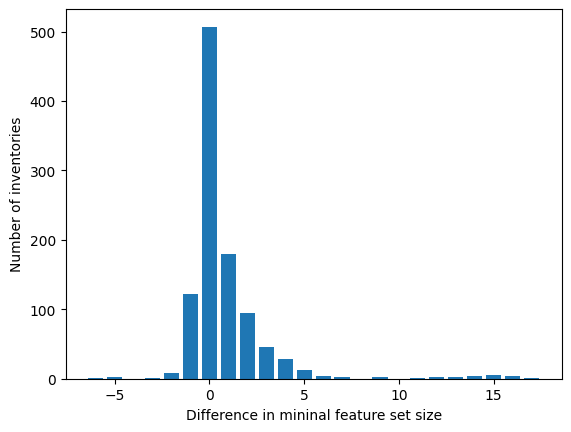

In [34]:
# Create the bar plot
plt.bar(x, y)

# Save the plot as an image file
plt.savefig('difference_vs_inventory_amount.png')

# Set labels and title
plt.xlabel('Difference in mininal feature set size')
plt.ylabel('Number of inventories')

# Show it!!!
plt.show()